# Task 1: Classification

1. define a Neural Network
2. define optimization procedure on FashionMNIST
3. train classifier on training set
4. evaluate model on test set
    - compute confusion matrix
    - compute Accuracy, Precision, Recall and F1 using the maximum response
    - visualize Precision-Recall curve for different classes 
    - visualize example images with predicted classes

In [21]:
import torch
import torchvision
import math

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from utils import NoisyFashionMNIST

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [22]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from skimage.metrics import structural_similarity as ssim

## Dataset: 
Downloads the FashionMNIST dataset in your local directory ./data  
The following code shows how to access and visualize the data.

In [23]:
transform=transforms.Compose([
        transforms.ToTensor()])

train_dataset = datasets.FashionMNIST("./data", train = True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()} # .class_to_idx.items() is a dictionary that maps class labels to numerical indexes

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


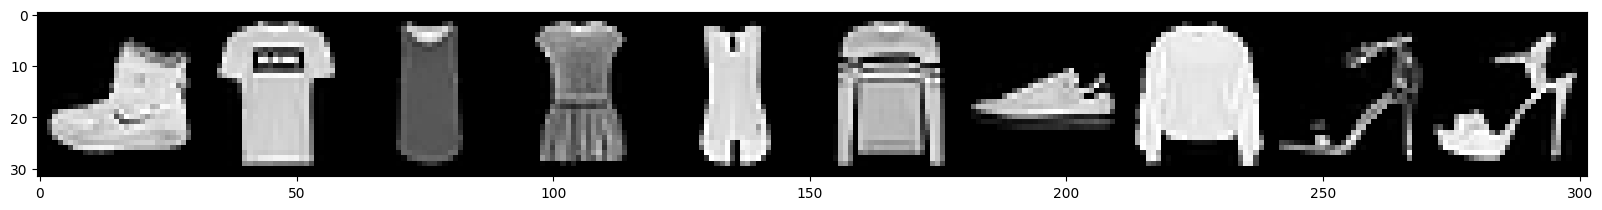

In [24]:
x = [train_dataset[i][0] for i in range(10)]
L = [idx_to_class[train_dataset[i][1]] for i in range(10)]
print(L)

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(x, nrow=10))
plt.show()

In [25]:
# 0. trainloader, loading the data into batches of 64 images
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
# 1. Define a neural network
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.bn1 = nn.BatchNorm1d(128)
    self.fc2 = nn.Linear(128,64)
    self.bn2 = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64,10)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.bn1(self.fc1(x)))
    x = F.relu(self.bn2(self.fc2(x)))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    
    return x
    
model = FMNIST()

In [27]:
# 2. Define an optimization procedure
from torch import optim

criterion = nn.NLLLoss()
# nn.NLLLoss() function expects the input to be logarithmized probabilities (logits) and the target to be class labels. 
# It calculates the negative log-likelihood loss between the predicted probabilities and the true labels
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [28]:
# 3. Train classifier on training set
num_epochs = 10

for i in range(num_epochs):
    cum_loss = 0

    for images, labels in train_loader :
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        cum_loss += loss.item()
    
    print(f'Training Loss: {cum_loss/len(train_loader)}') # average loss per batch

Training Loss: 0.6999335636271596
Training Loss: 0.4260136224885485
Training Loss: 0.3746621081474493
Training Loss: 0.3435609078388224
Training Loss: 0.3227736551576713
Training Loss: 0.30646114423076737
Training Loss: 0.2910121112092853
Training Loss: 0.2770847205334762
Training Loss: 0.267732751379008
Training Loss: 0.25772617394323033


[[786   1  14  54   3   2 132   0   8   0]
 [  1 969   1  24   1   0   2   0   2   0]
 [ 11   0 774  21  97   0  95   1   1   0]
 [ 16   9  11 930   8   1  23   0   2   0]
 [  0   1  81  64 777   0  73   0   4   0]
 [  0   0   0   1   0 948   0  35   1  15]
 [ 95   4  77  48  77   0 691   0   8   0]
 [  0   0   0   0   0  12   0 938   0  50]
 [  4   1   2   9   3   1  10   7 963   0]
 [  0   0   0   0   0  11   1  20   0 968]]
Accuracy score: 0.8744
Precision score: 0.8756236779074056
Recall score: 0.8744
F1 score: 0.8742955851886831


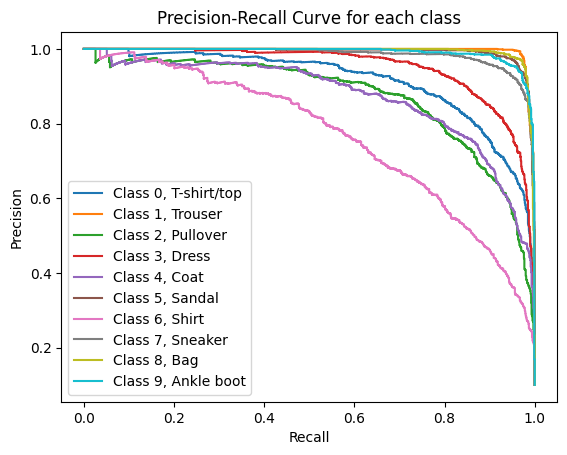

In [29]:
# 4. Evaluate the model on test set

test_data = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)

with torch.no_grad():
    data = next(iter(test_data))
    logps = model(data[0])
    output = torch.exp(logps)
    pred = torch.argmax(output,1)
    pred_array = pred.numpy()
    true_array = data[1].numpy()

    # 4.1 - compute confusion matrix
    cm = confusion_matrix(true_array, pred_array)
    print(cm)

    # 4.2 - compute Accuracy, Precision, Recall and F1 using the maximum response
    accuracy = accuracy_score(true_array, pred_array)
    precision = precision_score(true_array, pred_array, average='weighted') # for imbalanced class distributions. The weighted average takes into consideration the support (number of samples) for each class
    recall = recall_score(true_array, pred_array, average='weighted')
    f1 = f1_score(true_array, pred_array, average='weighted')
    print(f'Accuracy score: {accuracy}')
    print(f'Precision score: {precision}')
    print(f'Recall score: {recall}')
    print(f'F1 score: {f1}')

    # 4.3 - visualize Precision-Recall curve for different classes
    true_labels = true_array
    predicted_probabilities = output.numpy()

    # calculate precision and recall for each class
    precision = dict()
    recall = dict()
    for i in range(10):
        precision[i], recall[i], _ = precision_recall_curve(
            (true_labels == i).astype(int), predicted_probabilities[:, i])
    
    # plot Precision-Recall curve for each class
    plt.figure()
    for i in range(10):
        plt.step(recall[i], precision[i], where='post', label=f'Class {i}, {idx_to_class[i]}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for each class')
    plt.legend()
    plt.show()

<class 'list'>
[2 5 7 5 1 2 6 0 9 3]
['Pullover', 'Sandal', 'Sneaker', 'Ankle boot', 'Trouser', 'Coat', 'Shirt', 'T-shirt/top', 'Ankle boot', 'Dress']
['Pullover', 'Sandal', 'Sneaker', 'Sandal', 'Trouser', 'Pullover', 'Shirt', 'T-shirt/top', 'Ankle boot', 'Dress']


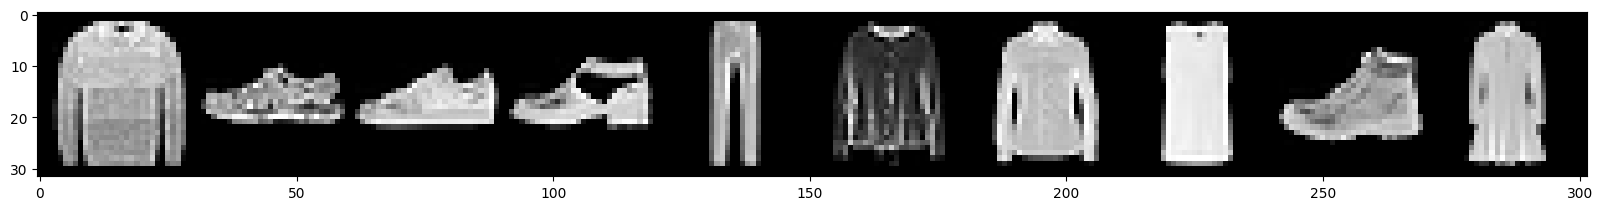

In [30]:
# 4.4 - visualize example images with predicted classes
first_batch = next(iter(test_loader))
print(type(first_batch))
images = first_batch[0][20:30]
labels = first_batch[1][20:30]

# list_pred_labels
logps = model(images)
ps = torch.exp(logps)
pred = torch.argmax(ps,1)
pred = pred.numpy()
print(pred)

true_labels = [idx_to_class[i] for i in labels.numpy()]
pred_labels = [idx_to_class[i] for i in pred]
print(true_labels)
print(pred_labels)

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(images, nrow=10))
plt.show()

# Task 2: Image Denoising
1. define a Neural Network
2. define optimization procedure on NoisyFashionMNIST
3. train denoising model
4. Evaluate model

## Dataset
Random augmentations are added to the original dataset.

In [31]:
train_dataset = NoisyFashionMNIST("./data", True)
test_dataset = NoisyFashionMNIST("./data", False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


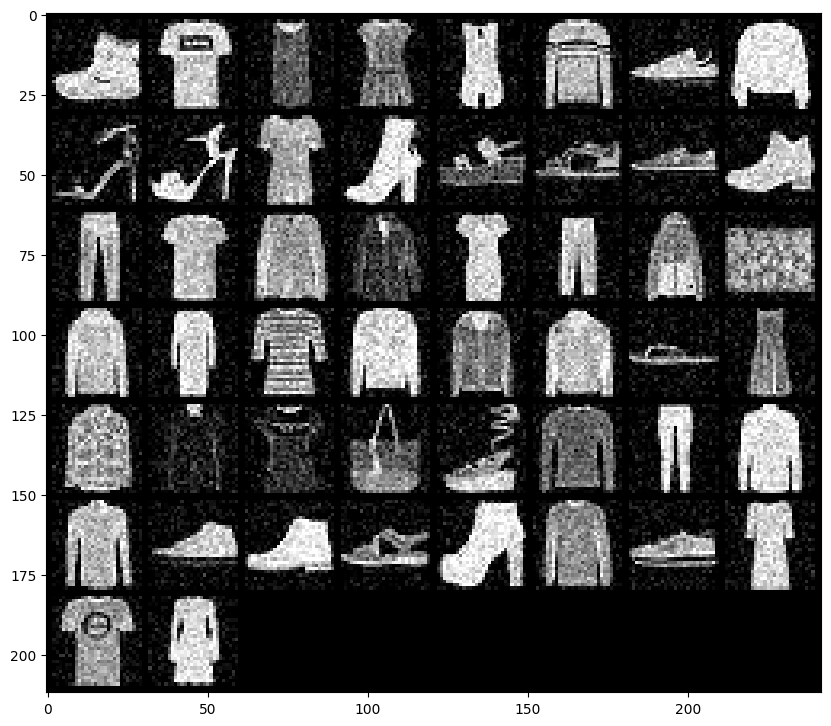

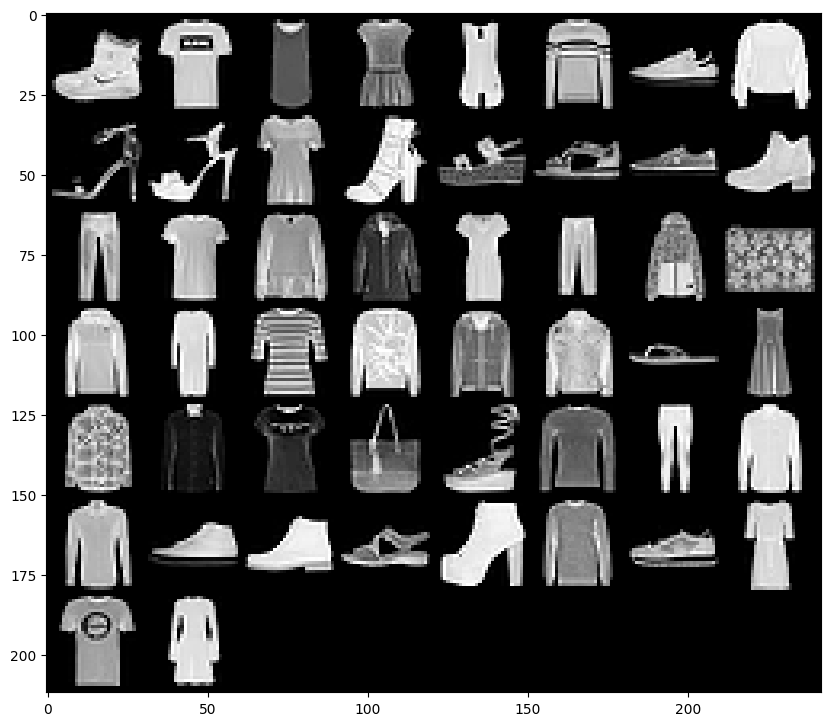

In [32]:
x = [train_dataset[i][0] for i in range(50)]
y = [train_dataset[i][1] for i in range(50)]

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(x))
plt.show()

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(y))
plt.show()

In [33]:
# 0. trainloader, loading the data into batches
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [34]:
# 1. Define the neural network
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        # encoder layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # a grey scale image has only one channel
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(2, 2)
        # decoder layers
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)
        self.bn4 = nn.BatchNorm2d(8)
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.bn5 = nn.BatchNorm2d(16)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)
    
    def forward(self, x):
        # encode
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        # decode
        x = F.relu(self.bn4(self.t_conv1(x)))
        x = F.relu(self.bn5(self.t_conv2(x)))
        x = F.relu(self.bn6(self.t_conv3(x)))
        x = F.sigmoid(self.conv_out(x))

        return x

model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (bn4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (bn5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (bn6): BatchNo

In [35]:
# 2. define optimization procedure on NoisyFashionMNIST
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [36]:
# 3. train denoising model
num_epochs = 5

for i in range(num_epochs):
    cum_loss = 0
    for img_noise, img in train_loader:
        optimizer.zero_grad()
        output = model(img_noise)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()*img.size(0)
    print(f'Training Loss at Epoch {i}: {cum_loss / len(train_loader)}')

Training Loss at Epoch 0: 1.2549522555014219
Training Loss at Epoch 1: 0.9441702359203082
Training Loss at Epoch 2: 0.8785247813536923
Training Loss at Epoch 3: 0.8474842988605946
Training Loss at Epoch 4: 0.8278838557157435


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


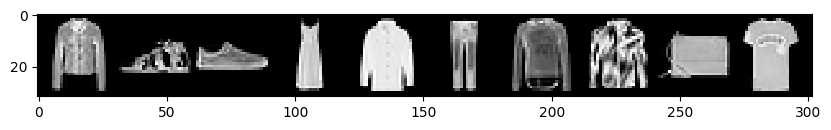

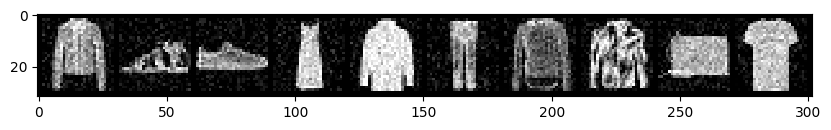

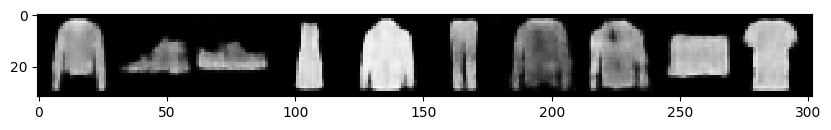

In [37]:
# 4. Evaluate model
# 4.1 visualizing some original input, noisy input, and reconstructed images
first_batch = next(iter(test_loader))
imgs_noise = first_batch[0][10:20]
imgs = first_batch[1][10:20]

imgs_pred = model(imgs_noise)

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(imgs, nrow=10))

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(imgs_noise, nrow=10))

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(imgs_pred, nrow=10))

In [38]:
# 4.2 Calculating the reconstructed images of the validation dataset
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)
data = next(iter(test_data))
output = model(data[0])

# Validation, noisy and reconstructed images arrays
val_noisy = data[0].numpy()
val_true = data[1].numpy()
val_predicted = output.detach().numpy()

In [39]:
# 4.3 calculating the Average PSNR and MSE on the validation dataset

def calculate_psnr(img1, img2, max_val=255):
    mse = np.mean((img2 - img1) ** 2)
    psnr = 10 * math.log10((max_val ** 2) / mse)
    return [mse, psnr]

n = 0
PSNR, MSE = 0, 0
PSNR_noisy, MSE_noisy = 0, 0

for t, p, s in zip(val_true, val_predicted, val_noisy):
    pred_img = t[0]
    true_img = p[0]
    noisy_img = s[0]
    # comparison between predicted and original image
    error = calculate_psnr(pred_img, true_img)
    MSE += error[0]
    PSNR += error[1]
    # comparison between predicted and original image
    error_noisy = calculate_psnr(noisy_img, true_img)
    MSE_noisy += error_noisy[0]
    PSNR_noisy += error_noisy[1]
    n += 1


print(f'Average MSE between true and predicted image: {MSE/n}, PSNR: {PSNR/n}')
print(f'Average MSE between true and noisy image: {MSE_noisy/n}, PSNR: {PSNR_noisy/n}')

Average MSE between true and predicted image: 0.012518268669885584, PSNR: 67.78014152924023
Average MSE between true and noisy image: 0.022023328754492102, PSNR: 64.90506941674722


In [40]:
# 4.4 calculating the Average SSIM on the validation dataset
SSIM = 0
SSIM_noisy = 0
n = 0
for t, p, s in zip(val_predicted, val_true, val_noisy):
    pred_img = t
    true_img = p
    noisy_img = s
    SSIM += ssim((pred_img[0]*255).astype('uint8'), (true_img[0]*255).astype('uint8'))
    SSIM_noisy += ssim((noisy_img[0]*255).astype('uint8'), (true_img[0]*255).astype('uint8'))
    n += 1

print(f'Average SSIM between original and reconstructed = {SSIM/n}')
print(f'Average SSIM between original and noisy = {SSIM_noisy/n}')

Average SSIM between original and reconstructed = 0.7121327476973841
Average SSIM between original and noisy = 0.22488526524508726


# Task 3: Model Selection

Conduct **3 experiments** for each of the previous tasks and document them.  
Evaluate the effect of different parameters on the classification and denoising tasks.  
Conduct the following experiments:

## I. Base case : neural network without residual connections, batch normalization, and base depth
### 1) classification (10 epochs)

With two hidden layers (of 128 and 64 nodes)
+ Accuracy score: 0.8328
+ Precision score: 0.8310576392133838
+ Recall score: 0.8328
+ F1 score: 0.8277607442135726

### 2) noisy (5 epochs)

In the encoder part, three layers contain respectively 32, 16, and 8 channels.
In the decoder part, three layers contain respectively 8, 16, and 32 channels.
+ Average MSE between true and reconstructed image: 0.015995556276338176, PSNR: 66.58321841846703
+ Average MSE between true and noisy image: 0.025575867862440645, PSNR: 64.24738418060747
+ Average SSIM between original and reconstructed = 0.6518136078018463
+ Average SSIM between original and noisy = 0.22513760592385879


## II. Experiments on the classification problem (Task 1)

### 1) Evaluate the effect of residual connections
Adding a residual connection between the 
+ Accuracy score: 0.8294
+ Precision score: 0.8276999791197964
+ Recall score: 0.8294
+ F1 score: 0.8267518735733028

Residual connections can help address the vanishing gradient problem and facilitate information flow. However, here this does not lead to improvements in term of performance, this may be due to the fact that the model is not deep enough, the added complexity from residual connections might not be beneficial and could potentially introduce noise or overfitting

### 2) Effect of the depth(number of layers)/width (number of channels or number of neurons) of the network

With four hidden layers, with respectively 256, 128, 64, 32 nodes :
+ Accuracy score: 0.8146
+ Precision score: 0.8201185265465581
+ Recall score: 0.8146
+ F1 score: 0.806171683181612

With 128, 64, 32
+ Accuracy score: 0.8383
+ Precision score: 0.8373365119404532
+ Recall score: 0.8383
+ F1 score: 0.8362767877555487

With 784, 784
+ Accuracy score: 0.8439
+ Precision score: 0.8454805147336576
+ Recall score: 0.8439
+ F1 score: 0.8428219281747245

### 3) Effect of Batch normalization

Adding batch normalization to the hidden layers :
With 128, 64
+ Accuracy score: 0.8761
+ Precision score: 0.8783260186859576
+ Recall score: 0.8761
+ F1 score: 0.8764444505035958


## III. Experiments on the denoising problem (Task 2)

### 1) Adding batch normalization to all the layers

+ Average MSE between true and predicted image: 0.012892993654008023, PSNR: 67.6224429083417
+ Average SSIM between original and reconstructed = 0.7043659060592865

### 2) Changing the loss function

Using the BCE (Binary Cross entropy loss) instead of the MSE
+ Average MSE between true and predicted image: 0.015851755430339835, PSNR: 66.64467385995874
+ Average SSIM between original and reconstructed = 0.6663857294687414

### 3) Changing the number of channels

In the encoder part, three layers contain respectively 16, 8, and 4 channels.
In the decoder part, three layers contain respectively 4, 8, and 16 channels.
+ Average MSE between true and predicted image: 0.030277818962512536, PSNR: 63.6552619875306
+ Average SSIM between original and reconstructed = 0.4663253111416154

In the encoder part, three layers contain respectively 64, 32, and 8 channels.
In the decoder part, three layers contain respectively 8, 32, and 64 channels.
+ Average MSE between true and predicted image: 0.01332750930399634, PSNR: 67.56298607701818
+ Average SSIM between original and reconstructed = 0.7008217717007669



## Optional experiments:
- How does the loss function affect denoising? Alternative loss functions: MSE, MAE, SSIM?
- How does Dropout affect the performance?
- Use different downsampling/upsampling layers, e.g.pooling, strided convolution, transposed convolution, etc.  
- Feel free to explore more variations of your model and training.